In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%matplotlib inline

In [294]:
pd.set_option('display.max_rows', 500)

## Read Data

In [295]:
# We have to set the column names since it does not come with one
col_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']

# Setting the file to the url location of dataset.
f = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original'

# Loading the dataset into our dataframe
df = pd.read_csv(f, names=col_names, delim_whitespace=True)

In [296]:
# For reference
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [297]:
# Lets check it out
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       406 non-null float64
displacement    406 non-null float64
horsepower      400 non-null float64
weight          406 non-null float64
acceleration    406 non-null float64
model_year      406 non-null float64
origin          406 non-null float64
car_name        406 non-null object
dtypes: float64(8), object(1)
memory usage: 28.6+ KB


## Clean Data

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Horsepower Distribution')

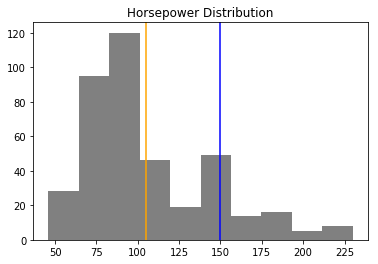

In [298]:
# Take a look at distribution of horsepower to see if we want to use mean or mode
plt.hist(df['horsepower'], color='grey');
plt.axvline(df['horsepower'].mean(), color='orange');
plt.axvline(df['horsepower'].mode()[0], color='blue');
plt.title('Horsepower Distribution')

In [299]:
# Fill na of horsepower
df['horsepower'].fillna(df['horsepower'].mean(), inplace=True)

In [300]:
# Get rid of na in mpg rows since that is what we are trying to predict
df.dropna(inplace=True)

In [301]:
# Check if any are 0 or negative
(df.iloc[:,:-1] <= 0).any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model_year      False
origin          False
dtype: bool

## Data Exploration

In [302]:
# Looking at correlation if we made car name into a dummy variable does not look promising; we will not do that.
# Maybe later.
abs(pd.get_dummies(df, columns=['car_name'], drop_first=True)).corr()['mpg']

mpg                                              1.000000
cylinders                                       -0.775396
displacement                                    -0.804203
horsepower                                      -0.771296
weight                                          -0.831741
acceleration                                     0.420289
model_year                                       0.579267
origin                                           0.563450
car_name_amc ambassador dpl                     -0.054743
car_name_amc ambassador sst                     -0.041884
car_name_amc concord                            -0.015154
car_name_amc concord d/l                        -0.034812
car_name_amc concord dl                         -0.003308
car_name_amc concord dl 6                       -0.021311
car_name_amc gremlin                            -0.051818
car_name_amc hornet                             -0.053432
car_name_amc hornet sportabout (sw)             -0.035455
car_name_amc m

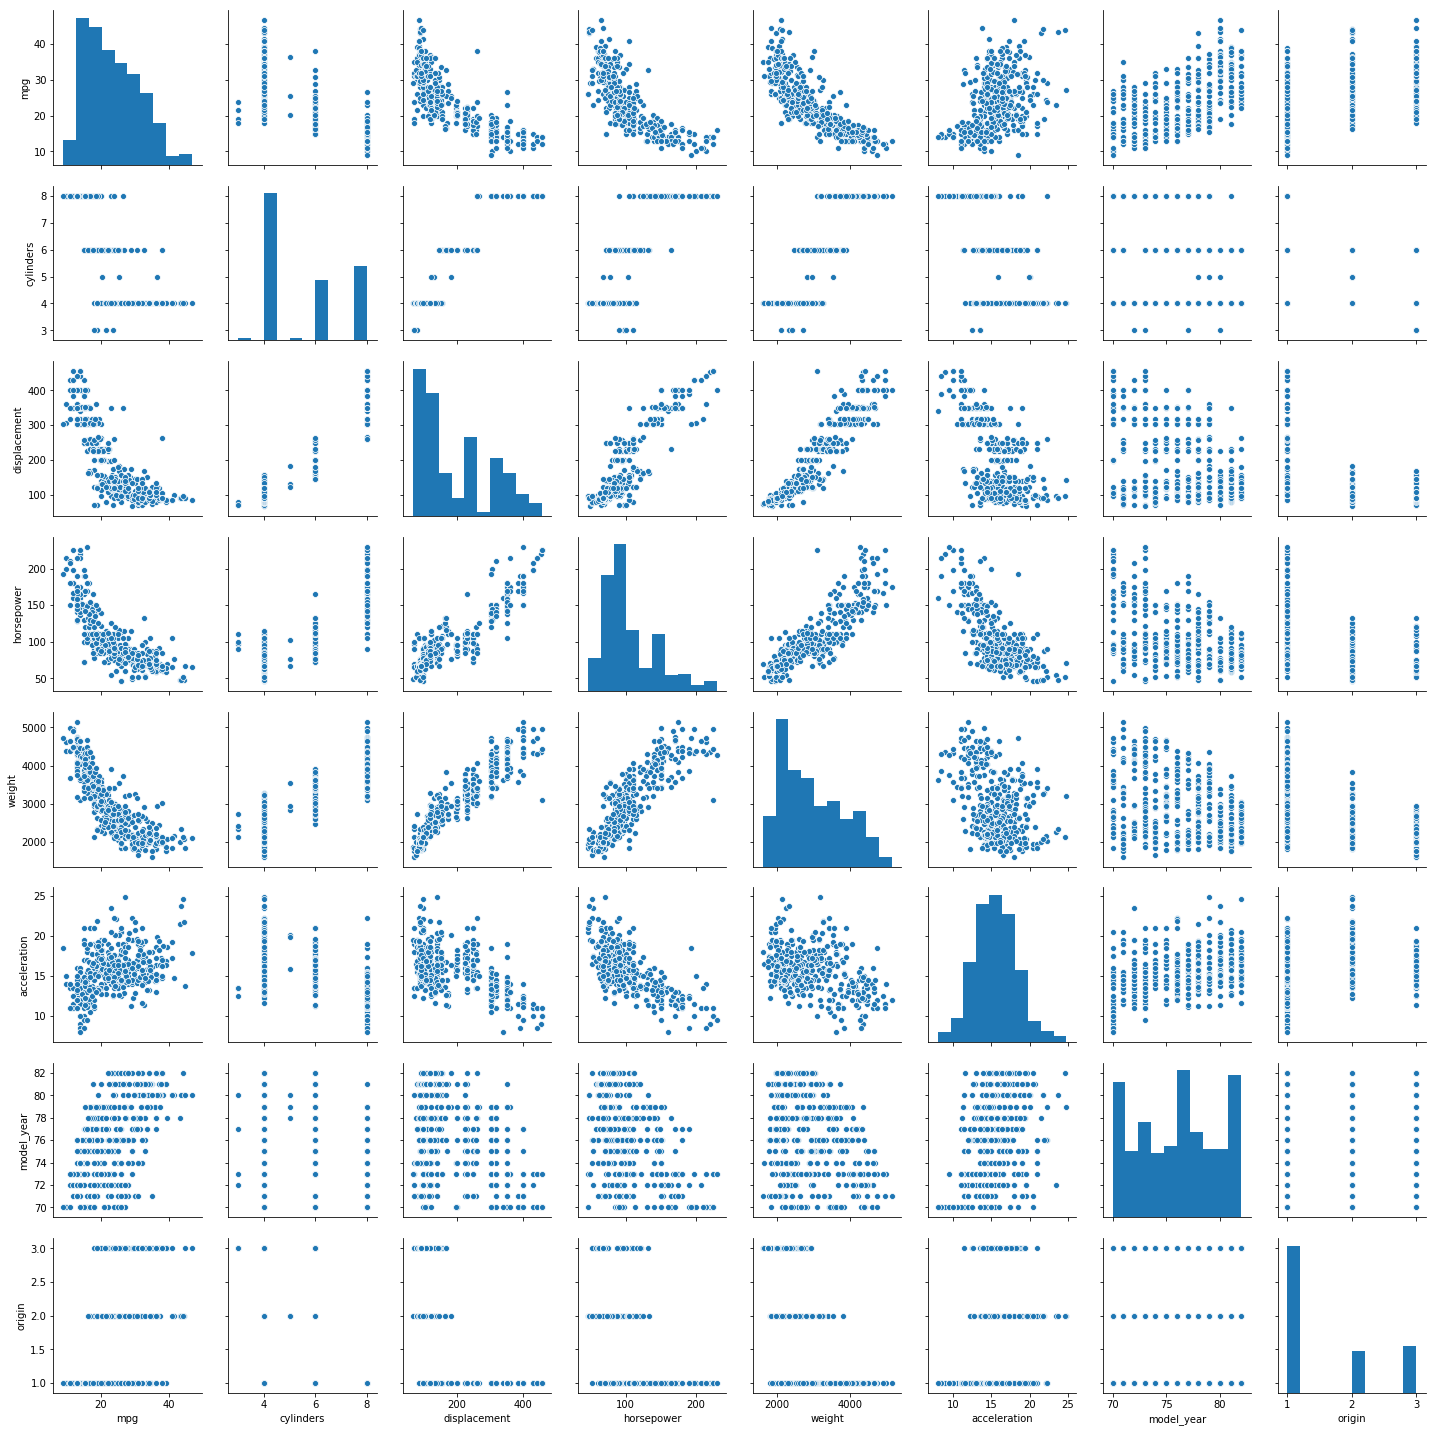

In [303]:
# Take a look at the relationship
sns.pairplot(df);

In [304]:
# Create features
features = df._get_numeric_data().columns[1:]

# Create features as string
feature_names = ' + '.join(features)

# Get y and X dataframes
y, X = dmatrices('mpg ~ ' + feature_names, df, return_type='dataframe')

# Create VIF
vif = pd.DataFrame()

# Load vif factor
vif['vif factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Load features
vif['features'] = X.columns

# Inspect
vif.round(1)

,vif factor,features
0,750.2,Intercept
1,10.7,cylinders
2,21.8,displacement
3,9.0,horsepower
4,10.5,weight
5,2.5,acceleration
6,1.2,model_year
7,1.7,origin


#### Drop displacement and redo VIF

In [305]:
# Create features
features = list(df._get_numeric_data().columns[1:])
features.remove('displacement')

# Create features as string
feature_names = ' + '.join(features)

# Get y and X dataframes
y, X = dmatrices('mpg ~ ' + feature_names, df, return_type='dataframe')

# Create VIF
vif = pd.DataFrame()

# Load vif factor
vif['vif factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Load features
vif['features'] = X.columns

# Inspect
vif.round(1)

,vif factor,features
0,747.1,Intercept
1,5.9,cylinders
2,8.3,horsepower
3,8.7,weight
4,2.5,acceleration
5,1.2,model_year
6,1.6,origin


In [306]:
X = df[features]
y = df['mpg']

X = sm.add_constant(X)

model = sm.OLS(y, X)

results = model.fit()

results.pvalues < .05

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const            True
cylinders       False
horsepower      False
weight           True
acceleration    False
model_year       True
origin           True
dtype: bool

In [307]:
features = ['weight', 'model_year', 'origin']

## Model

In [308]:
# Create X and y
X = df[features]
y = df['mpg']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Initiate mode
lr = LinearRegression()

# Fit model
lr.fit(X_train, y_train)

# Get predictions
test_predict = lr.predict(X_test)
train_predict = lr.predict(X_train)

# Score and compare
print(r2_score(y_test, test_predict))
print(r2_score(y_train, train_predict))

0.8350774853140814
0.811118050112767


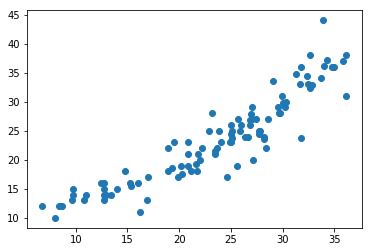

In [310]:
plt.scatter(test_predict, y_test)

In [312]:
export = pd.DataFrame({'Test Predictions': test_predict, 'Y': y_test})

In [313]:
export.to_csv('export.csv', index=False)